# TL;DR:

We've been developing buy/sell "classifiers" by training various "estimators" with historical market data. 

We've only been able to achieve classifications that are within the margin of error for randomness. This can be attributed to a variety of factors. Our approach might be inherently doomed. Our parameters are probably not optimal. Our computational power is limited. 

The bright side is that we have great room for improvement. We remain optimistic that future endeavors might yield lambos for all.

### Libraries

In [1]:
# TIME - Lord Chronos, Destroyer of All
import time

# Data Processing
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

# SciKit
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Poloniex
from poloniex import Poloniex
polo = Poloniex()

### Base Data

We look at 4 hour periods over the last 430 days. This is roughly the biggest length that we can use without corrupted data from Poloniex (eg. volume is zero, trading pair isn't that old, etc.).

We use trPairs as our training set and the complementary set tstPairs as our test set. In this case our training set is the first six pairs.

In [2]:
params = {
    'period' : 14400,    # 4 hours
    'length' : 2580,     # 4 hours * 2580 = 430 days
    'end' : time.time(), # Now
}
params['start'] = params['end'] - params['length'] * params['period']  # 430 days ago

pairs = [
    'USDT_BTC',
    'USDT_ETH',
    'BTC_ETH',
    'BTC_NMC',
    'USDT_XRP',
    'BTC_DASH',
    'USDT_DASH',
    'USDT_ETC',
    'USDT_LTC',
    'USDT_NXT',
    'USDT_REP',
    'USDT_STR',
    'USDT_XMR',
    'USDT_ZEC',
    #'USDT_BCH',
    'BTC_XRP',
    'BTC_LTC',
    'BTC_XMR',
    'BTC_FCT',
    'BTC_MAID',
    'BTC_BTS'
]
trPairs = pairs[:6]
tstPairs = list( set(pairs) - set(trPairs) )

### Indicators

We'll use several moving averages as indicators in addition to open, close, high, and low provided by Poloniex.

In [3]:
#Volume Weighted Moving Averages
mas = [4,8,16,32,64,128,256]

def vwma(price,volume,ma):
    return ( price * volume ).rolling(ma).sum() / volume.rolling(ma).sum()

### Load Data

We load data from Poloniex and parse it into a dataframe. 

We estimate the exchange price as the average of 'open' and 'weightedAverage' in the period following the signal in order to approximate lag. We hope to improve on this.

We calculate the value of holding for comparison with our generated strategies. We calculate our moving averages for use as base data.

In [4]:
def loadPolo(pair, params):
    
    raw = polo.returnChartData(currencyPair=pair,period=params['period'],start=params['start'],end=params['end'])
    
    # Generate dataframe from raw poloniex data
    df={ col:[]  for col in list(raw[0].keys()) }
    for i in range(len(raw)):
        for col in list( raw[0].keys()):
            df[col].append( float( raw[i][col] ) )
    df = pd.DataFrame( df, index=pd.to_datetime(df['date'],unit='s'))
    
    # Calculate price, hold value, and moving averages
    df.loc[:,'price'] = (( df.open + df.weightedAverage )/2).shift(-1)
    df.loc[:,'hold'] = np.log( df['price'].div( df['price'].iloc[0] ) )
    for ma in mas:
        df.loc[ma:,ma] = vwma(df['weightedAverage'],df['volume'],ma)
        
    # Check for bad values
    for i in range( len(df['volume']) ):
        if( df['volume'].iloc[i]  == 0 ): print(pair + ' ' + str(i))    
    
    return df

### Process Data

This function returns a base set and target set.

The base set consists of open, close, high, low and moving average columns. The columns are normalized by the weightedAverage, then rescaled logarithmically, then linearly scaled by 100 so values are roughly between 1 and -1. There's also a column for volume (normalized versus its average and then scaled logarithmically).

The target values are zero or one depending on the sign of the change in price.

We're considering adding the trading pair to the base, combining all market data into time slices, and the possible shapes of data more generally.

In [5]:
# Process dataframe into base and target
def processDf(df):
    return [
        100 * np.log( np.array(
            pd.concat([ 
                df[ mas + ['open','close','high','low'] ].div(df.weightedAverage,axis=0),
                df['volume'] / df['volume'].mean() 
            ],axis=1).iloc[max(mas):-2]
        )),
        np.array([ (1 if df.price.iloc[i] < df.price.iloc[i+1] else 0) for i in range(len(df)-2)]) ]

### Load and Process All Pairs

For each trading pair we store its dataframe, base set, and target set in the dictionary dfs.

In [6]:
%%time
dfs = {}
for pair in pairs:
    dfs[pair]={ 'df' : loadPolo(pair,params) }
    dfs[pair]['base'], dfs[pair]['df'].loc[:-2,'target'] = processDf( dfs[pair]['df'] )
    time.sleep(0.1)

print( 'Loaded {} pairs of length {}\n\n'.format(
    len(dfs),
    len(dfs[pairs[0]]['df'])
))

Loaded 20 pairs of length 2580


CPU times: user 7.17 s, sys: 104 ms, total: 7.28 s
Wall time: 21.3 s


### Classifier Parameters

We construct our training sets from our training pairs. It might be fun to do some folds, but I don't have time for that nonsense on my laptop.

We define our estimators and their parameters. There are a variety of optins in this department so we'll keep exploring. We usually search over a grid of parameters, but we've commented out the grid for quicker testing.

In [7]:
# Merge training data into training lists.
trBase = [base for X in [ dfs[pair]['base'] for pair in trPairs ] for base in X]
trTarget = [target for y in [ dfs[pair]['df']['target'].iloc[max(mas):-2] for pair in trPairs ] for target in y]

# Estimators and parameters
ests={
    'SVC':{
        'estimator':SVC(),
        'params':{
            'kernel':['rbf'], 
            'C':[70],                            #[65,70,75], 
            'gamma':[0.0001]                     #[0.00005, 0.0001, 0.0002]
        }
    },
    'MLP':{
        'estimator':MLPClassifier(),
        'params':{
            'solver':['lbfgs', 'sgd', 'adam']
        }
    },
    'SGD':{
        'estimator':SGDClassifier(),
        'params':{
            'alpha':[0.00002],                               #[0.00001, 0.00002, 0.00004],
            'epsilon': [0.005],                              #[0.0025,0.005, 0.01],
            'loss':['hinge','log','modified_huber'], 
            'max_iter':[ np.ceil( 10**6 / len(trTarget) ) ], #recommended by SciKit docs
            'power_t': [0.2],                                #[0.1,0.2,0.4],
            'penalty':['l2','l1','elasticnet'],
        }
    }
}

### Classifier Optimization

We use the function GridSearchCV to find and train classifiers optimized within the parameters above. This feels like Marco Polo. We hope to incorporate more sophisticated methods of optimization.

In [8]:
%%time
for est in ests.keys():
    ests[est]['clf'] = GridSearchCV(
            ests[est]['estimator'],
            ests[est]['params']
        ).fit( trBase, trTarget)
    print('{} best accuracy: {:.2f}% @ {}\n\n'.format(est, 100*ests[est]['clf'].best_score_, ests[est]['clf'].best_params_ ))

MLP best accuracy: 51.76% @ {'solver': 'lbfgs'}


SGD best accuracy: 51.62% @ {'max_iter': 72.0, 'epsilon': 0.005, 'alpha': 2e-05, 'loss': 'hinge', 'power_t': 0.2, 'penalty': 'elasticnet'}


SVC best accuracy: 51.41% @ {'C': 70, 'gamma': 0.0001, 'kernel': 'rbf'}


CPU times: user 2min 15s, sys: 1min 13s, total: 3min 29s
Wall time: 1min 59s


### Compute Value

We use the same old function to get the value of a portfolio over time. The totals are compounded and include Poloniex's trading fees. 

In [9]:
# Use Last/Open average for price. (or better)
def getValues(price,signal):
    value = 1.0
    values = []
    dates = []
    paid = False
    for i, sig in signal.iteritems():
        if sig and not paid:
            paid = price[i]
        elif not sig and paid:
            value *= price[i] / paid
            value *= 0.9975 * 0.9975
            paid = False
        if paid: values.append( 0.9975 * value * price[i] / paid )
        else: values.append(value)
        dates.append(i)
    return pd.Series(values,index=dates)

### Backtest

This function gets the values and related results for the target strategy and our classifier's strategy.

In [10]:
def getResult(pair,est,clf,df,base):

    # Get signal from classifier and compute value of strategy.
    df.loc[max(mas):-2,'clf'] = clf.best_estimator_.predict( base )
    df[est] = np.log(getValues(df['price'],df['clf']))

    # Get value of (optimal) target strategy
    df['targetVal'] = np.log(getValues(df['price'],df['target']))

    result = pd.Series({
        'pair':pair,
        'est':est,
        'score':'{:.2f}%'.format(100*clf.best_estimator_.score(base,df['target'].iloc[max(mas):-2])),
        'clf':'{:.2f}'.format(df[est].iloc[-2]),
        'hold':'{:.2f}'.format( df['hold'].iloc[-2] ),
        'ratio':'{:.2f}'.format( np.log( np.exp(df[est].iloc[-2]) / np.exp(df['hold'].iloc[-2] ) ) ),
        'target':'{:.2f}'.format(df['targetVal'].iloc[-3])
    })
    return df, result

### Calculating Results

We get the results for every trading pair and optimized estimator. We display these results in a table too huge to be useful. We hope to condense this information into a more useful format and/or incorporate sortable tables.

Apart from the percentage score our numbers are all in log scale. The ratio column represents the performace of our classifier versus holding. A positive or negative ratio indicates how much our classifier performs better or worse (resp.) than holding.

We tacked on a combo strategy that buys or sells according to the "votes" of our classifiers.

In [11]:
%%time
results = pd.DataFrame(columns=['pair','est','score','ratio','clf','hold','target'])

for pair in tstPairs:
    dfs[pair]['df'].loc[:,'combo'] = [0 for i in range( len( dfs[pair]['df'].index ) ) ]
    for est in ests:
        dfs[pair]['df'], result = getResult( pair, est, ests[est]['clf'] , dfs[pair]['df'], dfs[pair]['base'])
        dfs[pair]['df']['combo'] +=  dfs[pair]['df']['clf']
        results = results.append(result,ignore_index=True)
        
    dfs[pair]['df']['combo'] = [ ( 1 if len(ests) / 2.0 < dfs[pair]['df']['combo'].iloc[i] else 0 ) for i in range( len(dfs[pair]['df'].index) ) ] 
    result['score'] = '{:.2f}%'.format( 100 * ( len( dfs[pair]['df'].iloc[max(mas):-2] ) - ( ( dfs[pair]['df']['combo'].iloc[max(mas):-2] + dfs[pair]['df']['target'].iloc[max(mas):-2] ) % 2 ).sum() ) / len( dfs[pair]['df'].iloc[max(mas):-2] ) )
    dfs[pair]['df']['combo'] = np.log(getValues(dfs[pair]['df']['price'],dfs[pair]['df']['combo']))   
    result['est']='combo'
    result['clf'] = '{:.2f}'.format(dfs[pair]['df']['combo'].iloc[-2])
    result['ratio'] = '{:.2f}'.format(np.log( np.exp(float(result['clf'])) / np.exp(float(result['hold'])) ))
    results = results.append(result,ignore_index=True)        

iplot( ff.create_table(results) ) 

CPU times: user 55.5 s, sys: 6.92 s, total: 1min 2s
Wall time: 53.9 s


### Graph Results

We graph the values of our classifiers versus holding. Holding most often seems the best strategy.

In [20]:
def graphResult(pair, df):
    print('\n'+pair)

    #Plot values
    df.plot(
        y=['weightedAverage','hold','combo'] + list(ests.keys()),
        secondary_y=['hold','combo'] + list(ests.keys()),
        style = [':', '--', '-.'] + ['-' for i in range(len(ests))],
        figsize=(14,7)
    )
    plt.ylabel("Log Scale FTW")
    plt.show()


USDT_REP


/home/ahab/Projects/backtest/backtest_env/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



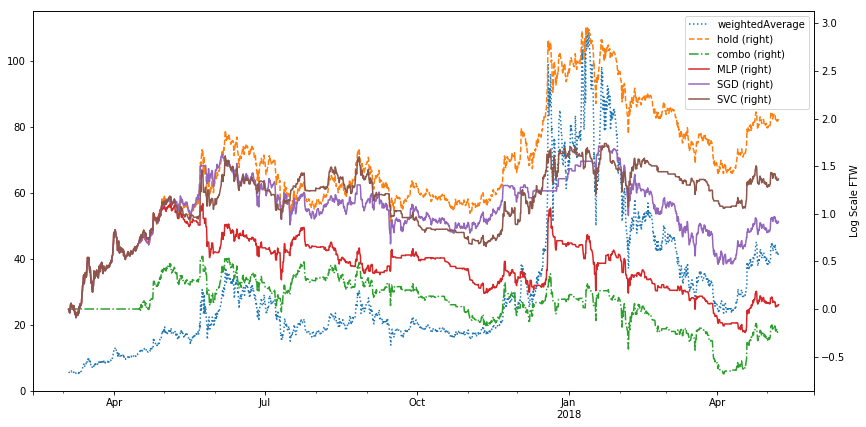


USDT_LTC


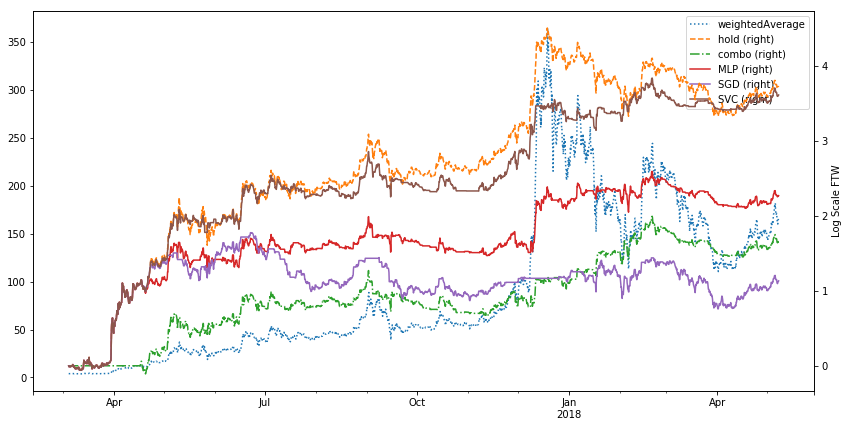


USDT_DASH


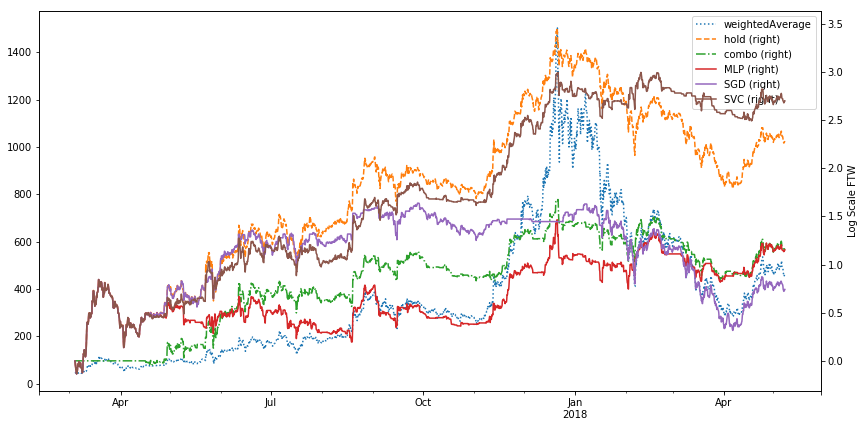


BTC_BTS


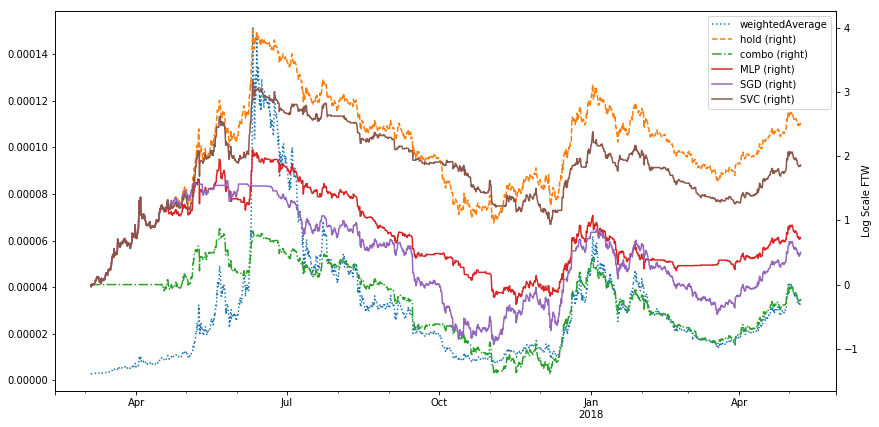


BTC_FCT


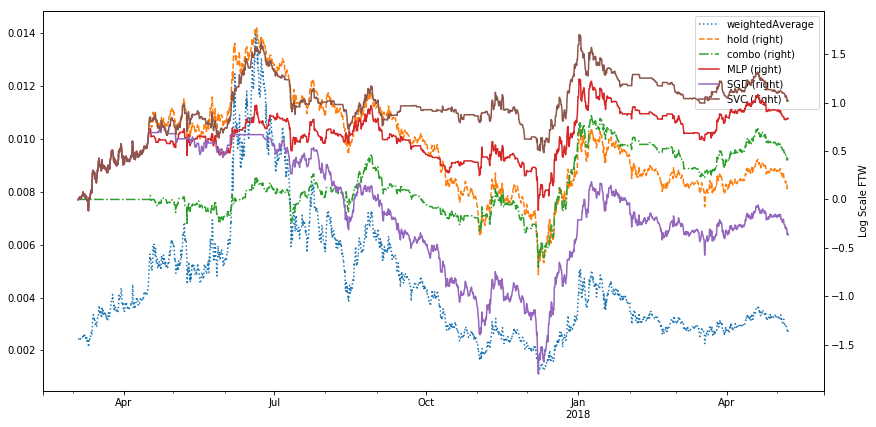


BTC_XRP


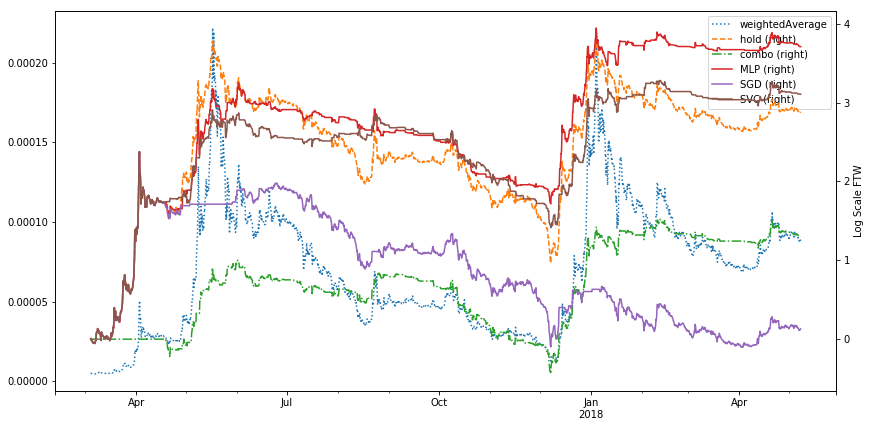


USDT_ZEC


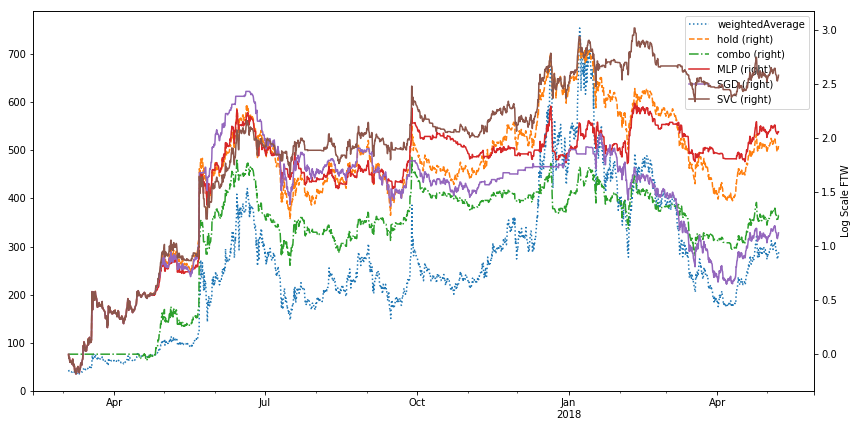


BTC_LTC


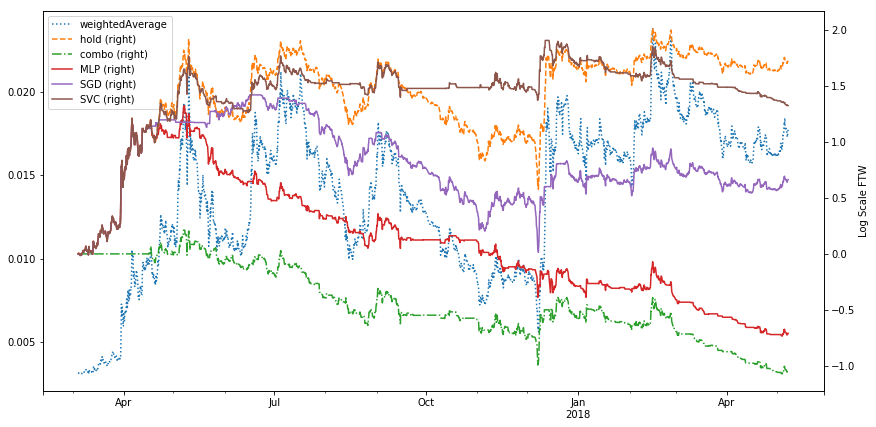


BTC_XMR


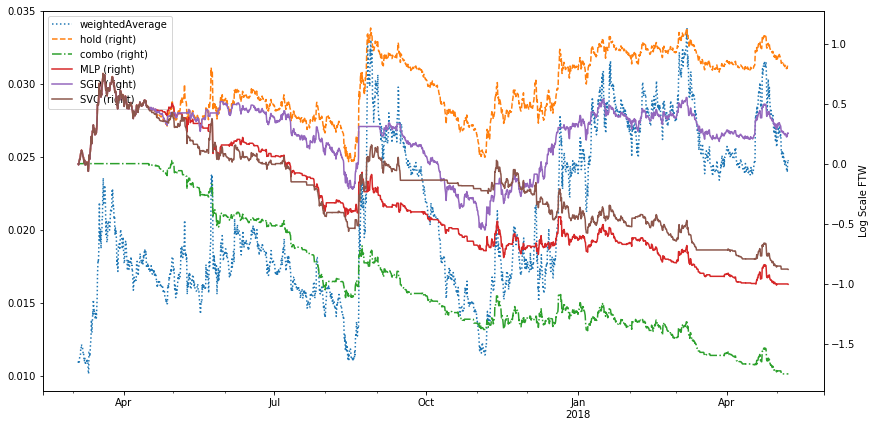


USDT_XMR


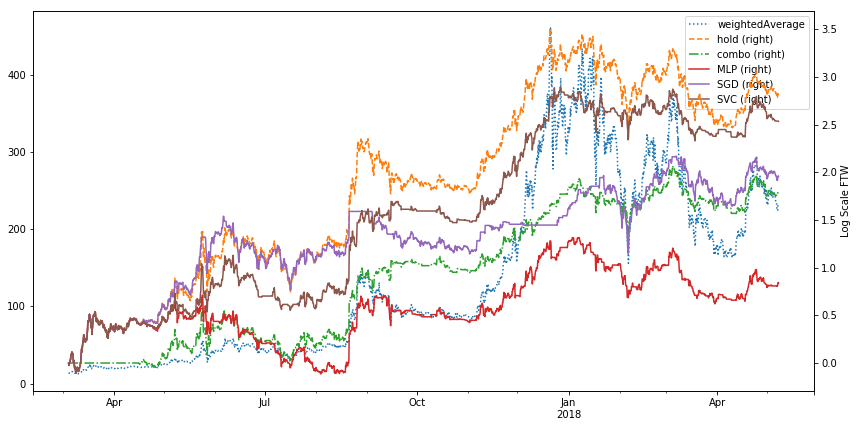


USDT_NXT


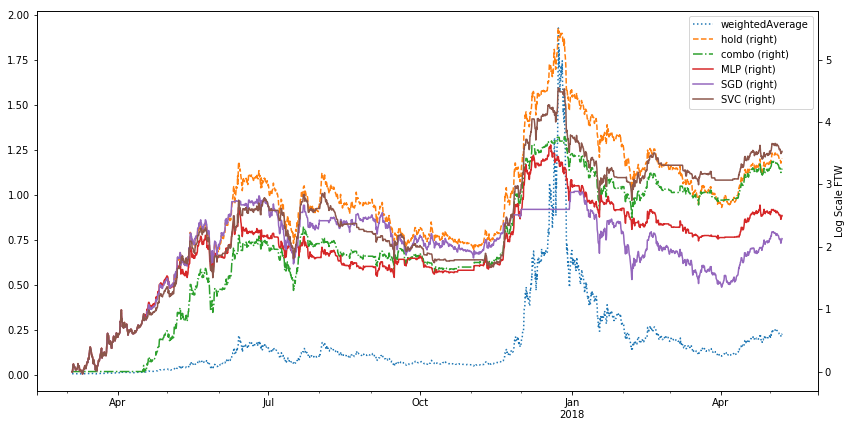


USDT_ETC


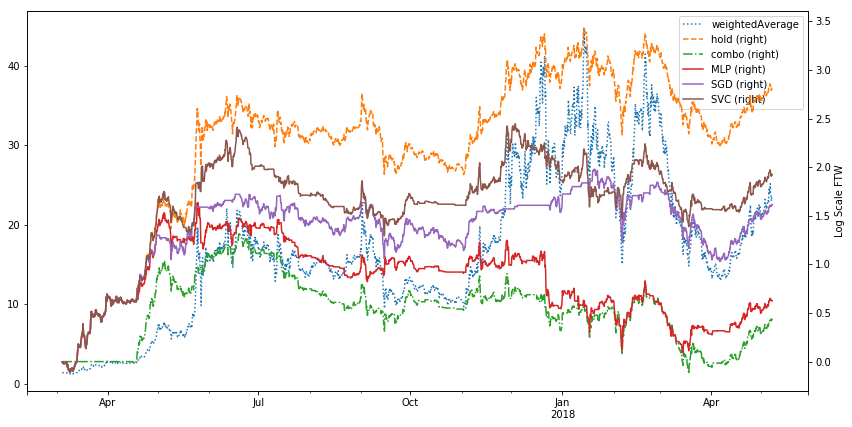


USDT_STR


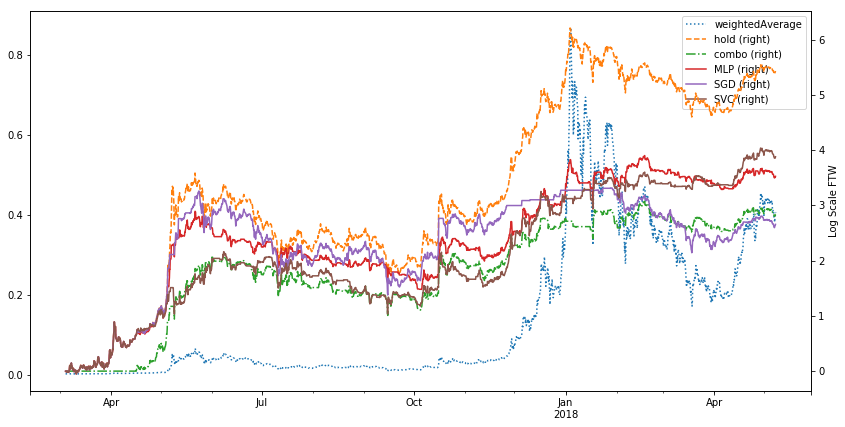


BTC_MAID


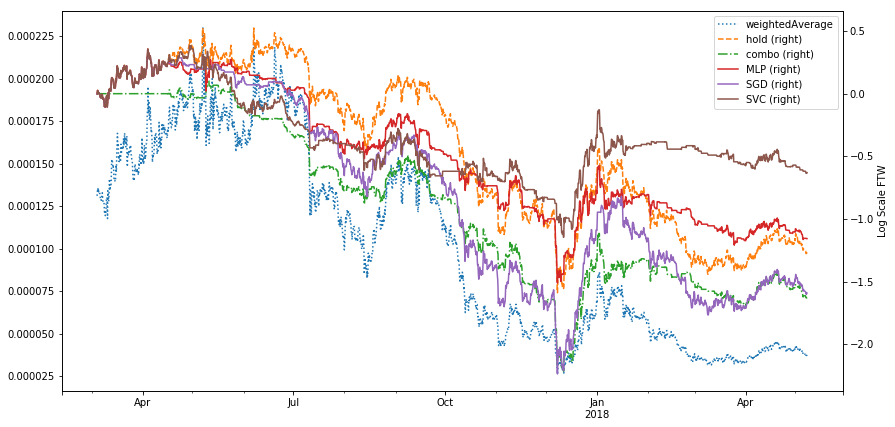

In [21]:
for pair in tstPairs:
    graphResult(pair,dfs[pair]['df'])